Try to wrangle the text file into a list of sentences.

In [ ]:
Before you run this you need to create a table in a postgress database 

create table embeddings (ID SERIAL PRIMARY KEY,                           
                         author text, line int, book text, embedding bytea, snippit text, model text);

In [4]:
import os 
import psycopg2 
import IProgress 
import pickle 
import numpy
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer


In [5]:
#these are simple convenience functions that the data prep uses. 

def get_and_tokenise(play):
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    fp = open("shakespeare-db/"+play)
    data = fp.read()
    tokens = sent_tokenize(data)
    new_tokens = [n.split('\n', 1)[1] for n in tokens if len(n.split('\n',1)) > 1]
    next_tokens = [u for u in new_tokens]
    return next_tokens

def embed(tokens, model):
    #do the embeddings 
    sentences = tokens
    model = SentenceTransformer('sentence-transformers/'+model)
    embeddings = model.encode(sentences,show_progress_bar=True)
    return embeddings


The code below is the main function that imports the model and then creates the embeddings before stuffing them into a data base for reuse. Each row in the database will be an embedding with metadata about what it embeds and the model used. 

In [2]:
model = "all-MiniLM-L12-v1"
plays = os.listdir("shakespeare-db")
conn = psycopg2.connect("dbname=postgres user=postgres password=postgres")
conn.autocommit = True
cur = conn.cursor()
        
for play in plays: 
    print (play)
    count = 0;
    tokens = get_and_tokenise(play)
    embeddings = embed(tokens, model)

    for this_token, this_embed in zip(tokens, embeddings):
        cur.execute('INSERT into embeddings (author,book,line, embedding, snippit,model) \
                    values (%s,%s,%s,%s,%s,%s) ',("Shakespear",play,count,pickle.dumps(this_embed),this_token,model))
        count=count+1
    print ("lines embedded =", count)
    

As You Like It.txt


NameError: name 'get_and_tokenise' is not defined

The database now has all the embeddings in it so we can start to use them. 
Retrive all the Shakespeare ones in the next cell. 

In [6]:
model = "all-MiniLM-L12-v1"
conn = psycopg2.connect("dbname=postgres user=postgres password=postgres")
cur = conn.cursor()
cur.execute('SELECT id, book,line,embedding from embeddings where embeddings.author=%s',("Shakespear",))
embeddings = cur.fetchall()

In [6]:
embeddings

[(35098, 'As You Like It.txt', 140, <memory at 0x7febdef74dc0>),
 (35099, 'As You Like It.txt', 141, <memory at 0x7febdef74e80>),
 (35100, 'As You Like It.txt', 142, <memory at 0x7febdef74f40>),
 (35101, 'As You Like It.txt', 143, <memory at 0x7febdef74c40>),
 (35102, 'As You Like It.txt', 144, <memory at 0x7febdef74b80>),
 (35103, 'As You Like It.txt', 145, <memory at 0x7febdefd2040>),
 (35104, 'As You Like It.txt', 146, <memory at 0x7febdefd2100>),
 (35105, 'As You Like It.txt', 147, <memory at 0x7febdefd21c0>),
 (35106, 'As You Like It.txt', 148, <memory at 0x7febdefd2280>),
 (35107, 'As You Like It.txt', 149, <memory at 0x7febdefd2340>),
 (35108, 'As You Like It.txt', 150, <memory at 0x7febdefd2400>),
 (35109, 'As You Like It.txt', 151, <memory at 0x7febdefd24c0>),
 (35110, 'As You Like It.txt', 152, <memory at 0x7febdefd2580>),
 (35111, 'As You Like It.txt', 153, <memory at 0x7febdefd2640>),
 (35112, 'As You Like It.txt', 154, <memory at 0x7febdefd2700>),
 (35113, 'As You Like It.

In [7]:
import faiss

Now set the data structure up to use Faiss

In [8]:
key =[]
value = []
items = len(embeddings)
key_value = [[0 for x in range(3)] for y in range(items)] 

count = 0

#count and for is bad... but clear 
for D in embeddings:
    key=D[0] # should be the id field from postgress - should be unique and key
    value = bytes(D[3]) # D[3] should be the embedding as a bytea created by pickle.dump 
    key_value[count][0]=key
    key_value[count][1]=pickle.loads(bytes(value)) #unpickle the value from D[3] - tell python it's bytes. 
    count=count+1

    

In [9]:
import numpy as np
arr = np.array(key_value)
embeddings = np.array([embedding for embedding in arr[:,1]]).astype("float32")

<ipython-input-9-13ef05ef42ee>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.array(key_value)


In [10]:
#idds= numpy.arange(any, len(arr[:,0]), dtype="int64")#.astype('int64')
idds=arr[:,0]
idds = idds.copy(order='C').astype('int64')

In [10]:
embeddings

array([[ 0.08040225,  0.12598377,  0.09745149, ...,  0.05144682,
        -0.0146205 , -0.01885655],
       [-0.00612251,  0.04832892,  0.08627935, ..., -0.03951882,
        -0.05325108,  0.05043194],
       [-0.01785206,  0.00076679,  0.10930776, ...,  0.0833272 ,
         0.03059571, -0.00564204],
       ...,
       [ 0.01452838,  0.07053237, -0.03795956, ..., -0.02179181,
         0.05286616, -0.04377155],
       [-0.04220096,  0.05377195,  0.06067434, ...,  0.04563998,
         0.05898713, -0.01594879],
       [ 0.04360894,  0.04844649, -0.01587826, ..., -0.00419272,
         0.05998175,  0.02838317]], dtype=float32)

So - now create an index that can be used to find nearest neighbours according to the language model 

In [11]:
#embeddings = np.array([embedding for embedding in key_value[1]]).astype("float32")
labels =arr[:,0].copy(order='C')
# Step 2: Instantiate the index
index = faiss.IndexFlatL2(embeddings.shape[1])

# Step 3: Pass the index to IndexIDMap
index = faiss.IndexIDMap(index)

# Step 4: Add vectors and their IDs
index.add_with_ids(embeddings, idds)



The cell below queries for the nearest neighbours of an arbitary embedding 

Pretty print the results of a query 

In [18]:
D, I = index.search(numpy.array([embeddings[100]]), k=10)
conn = psycopg2.connect("dbname=postgres user=postgres password=postgres")
cur = conn.cursor()
neighbours = I[0]
for neighbour in neighbours :
    cur.execute('SELECT book,line,snippit from embeddings where embeddings.id=%s',(str(neighbour),))
    refs  = cur.fetchall()
    print (refs[0][0], "\t", refs[0][1], "\t",refs[0][2],"\n")

As You Like It.txt 	 86 	      Indeed, there is Fortune too hard for Nature, when
     Fortune makes Nature's natural the cutter-off of
     Nature's wit. 

As You Like It.txt 	 82 	      Nay, now thou goest from Fortune's office to
     Nature's: Fortune reigns in gifts of the world,
     not in the lineaments of Nature. 

King John.txt 	 290 	      Nature and Fortune join'd to make thee great:
     Of Nature's gifts thou mayst with lilies boast,
     And with the half-blown rose. 

Merry Wives of Windsor.txt 	 799 	      what thou wert, if Fortune thy foe were not, Nature
     thy friend. 

Love's Labour's Lost.txt 	 236 	      As Nature was in making graces dear
     When she did starve the general world beside
     And prodigally gave them all to you. 

As You Like It.txt 	 87 	      Peradventure this is not Fortune's work neither, but
     Nature's; who perceiveth our natural wits too dull
     to reason of such goddesses and hath sent this
     natural for our whetstone; for alwa

In [12]:
D

array([[0.        , 0.7646222 , 0.77018774, 0.84607553, 0.84947324,
        0.86867416, 0.88350713, 0.88385713, 0.88795406, 0.89648974]],
      dtype=float32)

In [13]:
import networkx as nx
G = nx.Graph()
conn = psycopg2.connect("dbname=postgres user=postgres password=postgres")
cur = conn.cursor()
for line in embeddings :
    D, I = index.search(numpy.array([line]), k=5)
    cur.execute('SELECT book,line,snippit from embeddings where embeddings.id=%s',(str(I[0][0]),))
    origin  = cur.fetchall()[0][0]
    for edge in I[0]:
        cur.execute('SELECT book,line,snippit from embeddings where embeddings.id=%s',(str(edge),))
        connection  = cur.fetchall()[0][0]
        G.add_edge(origin,connection) #adds an edge to itself, which might need to be removed. 
        
       

In [14]:
import matplotlib.pyplot as plt

In [13]:
nx.write_graphml(G, "shakespeare-graph.graphml")

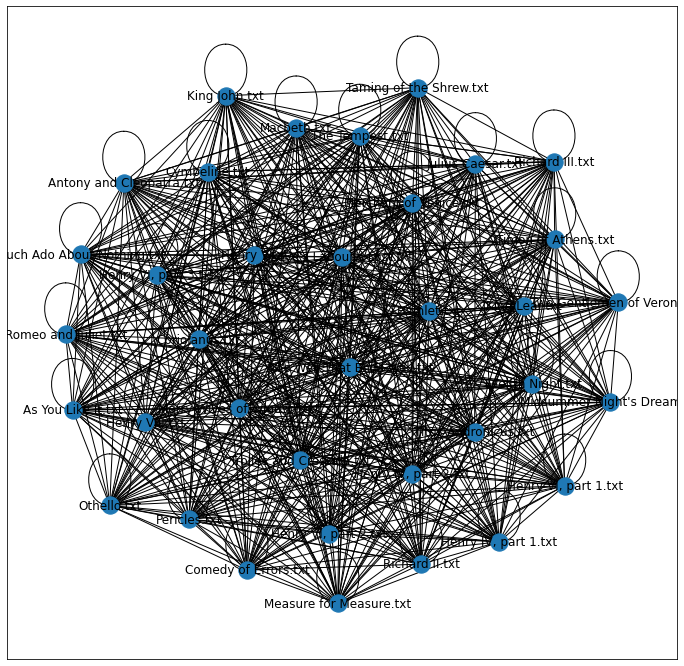

In [14]:

#nx.draw_networkx(G)
plt.figure(3,figsize=(12,12)) 
nx.draw_networkx(G)
plt.show()


In [43]:
conn = psycopg2.connect("dbname=postgres user=postgres password=postgres")
cur = conn.cursor()
#get the list of books 
cur.execute('SELECT book from embeddings where embeddings.author=%s group by book',("Shakespear",))
books = cur.fetchall()
newbooks = []
for book in books:
    newbooks.append(book[0])
    

#create results array   
links_clean = np.zeros([len(newbooks),len(newbooks)])
for line in embeddings :
    D, I = index.search(numpy.array([line]), k=10)
    cur.execute('SELECT book,line,snippit from embeddings where embeddings.id=%s',(str(I[0][0]),))
    origin  = cur.fetchall()[0][0]
    origin_pos = newbooks.index(origin)
  
    for edge in I[0]:
        count = 1
        cur.execute('SELECT book,line,snippit from embeddings where embeddings.id=%s',(str(edge),))
        connection  = cur.fetchall()[0][0]
        connection_pos = newbooks.index(connection)
        if (connection_pos!=origin_pos):
            current_val = links_clean[origin_pos][connection_pos]
            delta = 1.0 - D[0][count] #is this embedding considered "close" by faiss?
            if delta > 0.20 :         
                links_clean[origin_pos][connection_pos] =current_val + delta
            count=count+1
      


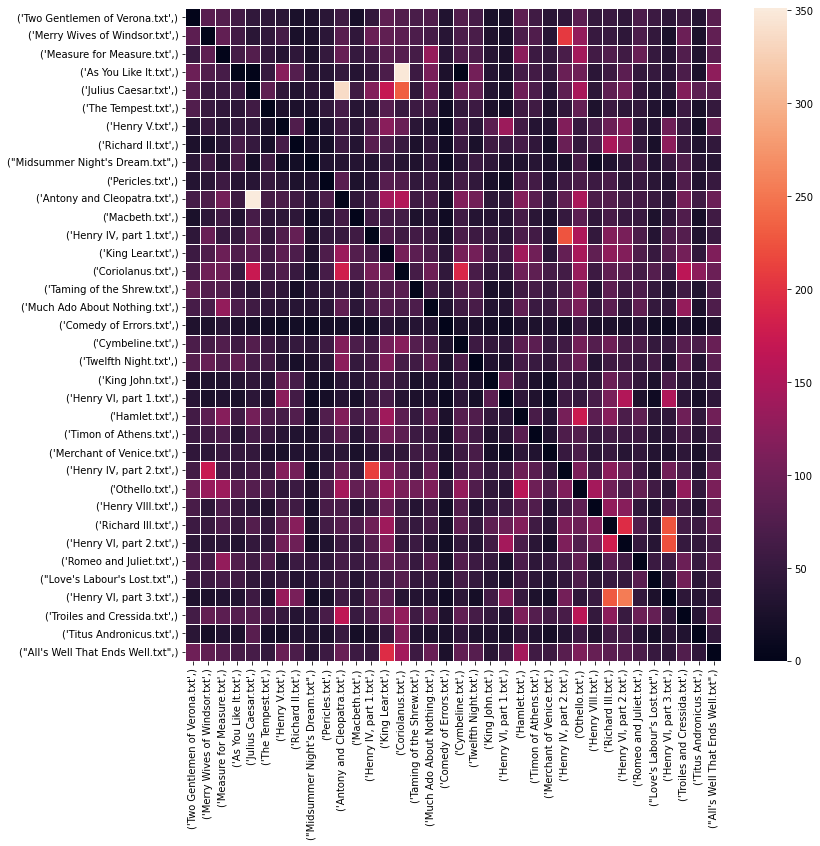

In [63]:
links_messy = np.copy(links_clean) # don't ruin the data 
links_messy[3][4]=0.0 # clean out the anomaly 
links_messy[3][18]=0.0 # clean out the anomaly 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(3,figsize=(12,12)) 
uniform_data = np.random.rand(10, 12)
x_axis_labels = books
y_axis_labels = books
ax = sns.heatmap(links_messy, linewidth=0.5,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()

In [30]:
links_clean[6]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
#### summed=np.sum(links_clean,axis=1).tolist()

In [52]:
import pandas as pd
summed=np.sum(links_messy,axis=1).tolist()
df = pd.DataFrame({'Books':books, 'summed':summed})
df.sort_values('summed')

,Books,summed
17,"(Comedy of Errors.txt,)",886.049614
34,"(Titus Andronicus.txt,)",1313.390691
8,"(Midsummer Night's Dream.txt,)",1339.529750
24,"(Merchant of Venice.txt,)",1412.886251
20,"(King John.txt,)",1549.061511
5,"(The Tempest.txt,)",1594.000455
11,"(Macbeth.txt,)",1599.722210
21,"(Henry VI, part 1.txt,)",1646.114460
9,"(Pericles.txt,)",1669.927509
31,"(Love's Labour's Lost.txt,)",1795.069056


In [108]:
df

,Books,summed
0,"(Two Gentlemen of Verona.txt,)",3321.0
1,"(Merry Wives of Windsor.txt,)",4075.0
2,"(Measure for Measure.txt,)",3997.0
3,"(As You Like It.txt,)",4210.0
4,"(Julius Caesar.txt,)",3530.0
5,"(The Tempest.txt,)",3266.0
6,"(Henry V.txt,)",3603.0
7,"(Richard II.txt,)",3061.0
8,"(Midsummer Night's Dream.txt,)",2316.0
9,"(Pericles.txt,)",3277.0


In [72]:
import networkx as nx
links_filtered = np.zeros([len(newbooks),len(newbooks)])
G = nx.Graph()
std=np.std(links_messy)
mean=np.mean(links_messy)
threshold = mean +(std*2)
print(threshold)
line_count=0
item_count=0

for line in links_clean:
    for item in line:
        if (item>threshold):     
            origin = books[line_count]
            connection=books[item_count]
            G.add_edge(origin,connection) 
            links_filtered[line_count][item_count] = item
        item_count=item_count+1
    line_count=line_count+1
    item_count=0


133.54644924809202


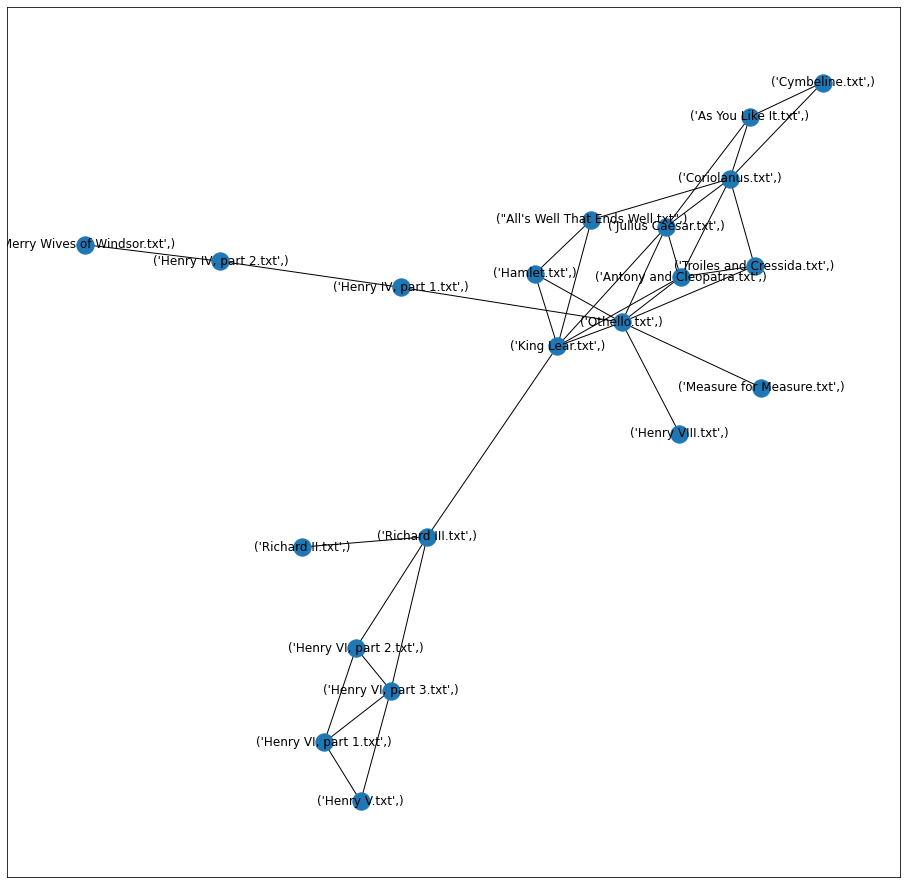

In [73]:
plt.figure(3,figsize=(16,16)) 
nx.draw_networkx(G,pos=nx.fruchterman_reingold_layout(G))
plt.show()


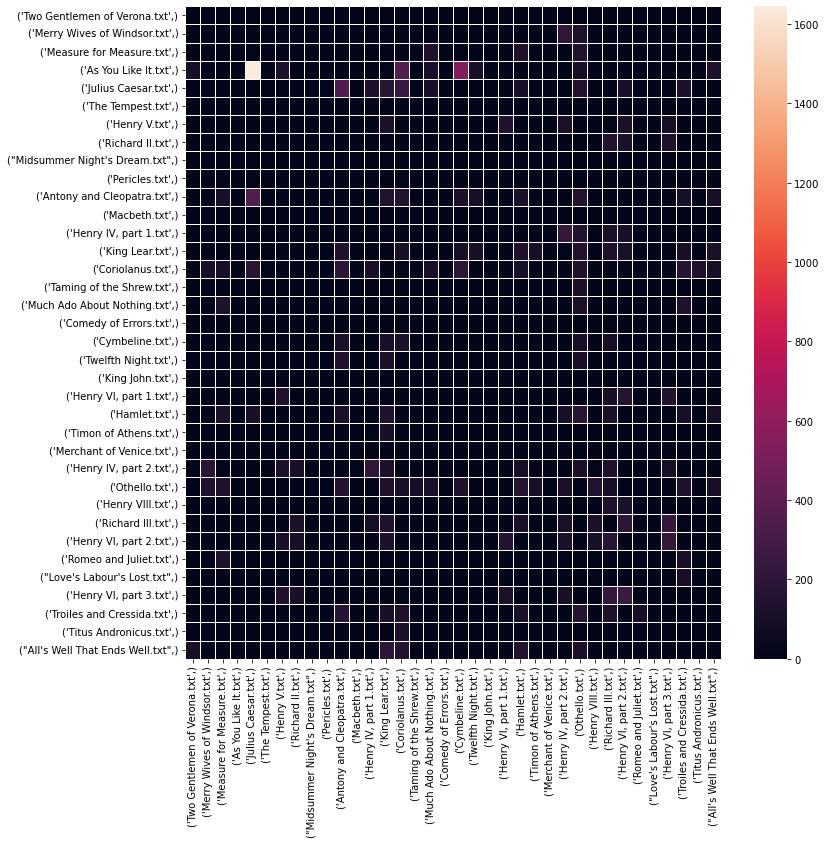

In [68]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(3,figsize=(12,12)) 
uniform_data = np.random.rand(10, 12)
x_axis_labels = books
y_axis_labels = books
ax = sns.heatmap(links_filtered, linewidth=0.5,xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.show()